Importamos las librerias. Algunas son para el uso de la GPU, otras son para el proyecto

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess
import cv2
from tensorflow.keras.callbacks import EarlyStopping



In [3]:
import tensorflow as tf
# Verificar si TensorFlow detecta GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-05-03 09:58:14.887957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 09:58:14.937433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 09:58:14.937835: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Para que el programa utilice la VRAM que tiene el sistema y no la RAM de la computadora

In [4]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


Leer la base de datos creada con anterioridad y ver su contenido

In [5]:
df = pd.read_hdf('BD_Emotions_Color_V1.h5')

In [6]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[[168, 186, 191], [168, 186, 190], [168, 186,...","[[[60, 69], [60, 74], [61, 80], [62, 86], [64,...","[[[24, 27, 34], [24, 25, 27], [32, 33, 35], [2...",focused
1,"[[[155, 169, 169], [155, 169, 169], [156, 170,...","[[[55, 59], [55, 65], [56, 72], [57, 78], [59,...","[[[155, 169, 170], [9, 18, 23], [7, 8, 9], [45...",focused
2,"[[[156, 165, 164], [157, 166, 165], [156, 165,...","[[[56, 74], [56, 81], [58, 88], [59, 96], [61,...","[[[17, 17, 19], [18, 18, 21], [15, 15, 15], [2...",focused
3,"[[[157, 171, 171], [159, 171, 171], [157, 171,...","[[[59, 83], [59, 90], [59, 97], [60, 104], [62...","[[[163, 177, 180], [140, 152, 155], [12, 17, 2...",focused
4,"[[[161, 175, 176], [159, 173, 173], [160, 174,...","[[[50, 66], [50, 73], [50, 80], [51, 87], [53,...","[[[161, 174, 180], [161, 174, 178], [160, 174,...",focused


Verificar que no sea irregular de imagen y rostro

In [7]:
print(df['Imagen'].shape)
print(df['Rostro'].shape)

(5039,)
(5039,)


Separamos las caracteristicas y etiquetas

In [8]:
# Separar las características y etiquetas
X = np.array(df['Rostro'])
y = df['Etiqueta']

Verificamos el formato, que sea ideal para la CNN

In [9]:
print(df['Imagen'].values[0].shape)
print(df['Rostro'].values[1].shape)

(150, 150, 3)
(51, 52, 3)


Dado que el formato de rostro puede ser menor o mayor medida, hay que adaptar todos los datos a un formato. En este caso lo escalamos a 150x150

In [10]:
print(X.shape)
print(X[0].shape)


(5039,)
(52, 51, 3)


In [11]:
for i in range(X.shape[0]):
    X[i] = np.array(Image.fromarray(X[i]).resize((150,150)))

In [12]:
#import numpy as np
#from PIL import Image

# Crear un nuevo array para almacenar las imágenes redimensionadas
#X_resized = np.empty((X.shape[0], 150, 150, 1), dtype=np.uint8)

# Iterar sobre cada imagen en X
#for i in range(X.shape[0]):
    # Obtener la imagen actual y redimensionarla
#    img_data = np.squeeze(X[i])  # Eliminar la dimensión de un solo canal
#    img_data_resized = np.array(Image.fromarray(img_data).resize((150, 150)))
#    # Agregar la dimensión del canal nuevamente
##    img_data_resized = np.expand_dims(img_data_resized, axis=-1)
 #   # Almacenar la imagen redimensionada en X_resized
#    X_resized[i] = img_data_resized

# Actualizar X con las imágenes redimensionadas
#X = X_resized



Verificamos el formato 

In [13]:
print(X[0].shape)

(150, 150, 3)


Codificamos el formato de las etiquetas para que estén en 0,1,2,3,4,5...

In [14]:
# Codificar las etiquetas
etiquetas = y.unique()
y_encoded = pd.Categorical(y, categories=etiquetas).codes

Verificamos que se haya transformado a un formato minimo y maximo

In [15]:
print(y_encoded)

[0 0 0 ... 5 5 5]


Hacemos los datos de entrenamiento y los de prueba

In [16]:

# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


Transformar las etiquetas a one_hot. Dependiendo la posición del numero es la etiqueta 

In [17]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

In [18]:
print(y_val_one_hot)
print("Clases originales:", df['Etiqueta'].unique())

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
Clases originales: ['focused' 'relaxed' 'excited' 'engaged' 'interested' 'bored']


Distribución visual de las etiquetas y su clasificacion

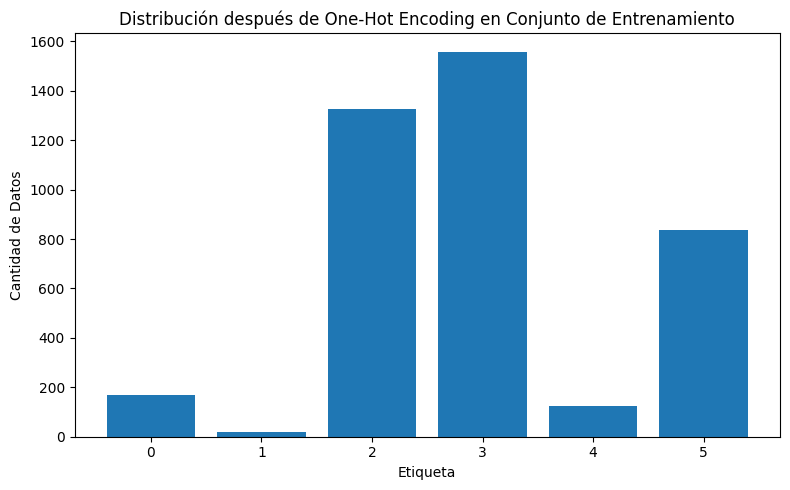

In [19]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

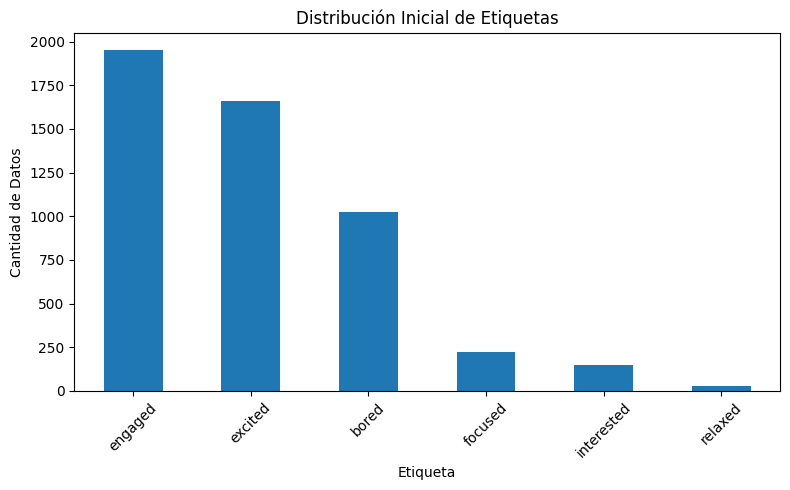

In [20]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalizamos los datos de entrenamiento y los de valores para verificar en numpy array

In [21]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

In [22]:
print(X_train.shape)
print(X_train[0].shape)

(4031, 150, 150, 3)
(150, 150, 3)


Todos los datos de entrenamiento los ponemos en tipo flotante 32 y lo dividimos en 255 (que es formato de imagen), esto para normalizar del 0 al 1

In [23]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [24]:
print(X_train.shape)
print(X_train[0].shape)

(4031, 150, 150, 3)
(150, 150, 3)


Generamos infinidad de imagenes (Muchas imagenes. No son infinitas). Definimos los patrones para generar más imagenes y que el modelo no se sobre ajuste

In [25]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



Aqui lo aumentamos.

In [31]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=50)


Todo el modelo definido

In [32]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])


Compilamos el modelo.

In [33]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Entrenamos el modelo

In [34]:
# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


In [35]:
# Entrenar el modelo con el callback de TensorBoard
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                    epochs=50,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    callbacks=[early_stopping]
                    )


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.4242 - loss: 1.4900 - val_accuracy: 0.5734 - val_loss: 0.9560
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step - accuracy: 0.5911 - loss: 0.8827 - val_accuracy: 0.5873 - val_loss: 0.9113
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - accuracy: 0.6066 - loss: 0.8571 - val_accuracy: 0.6359 - val_loss: 0.9039
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.6058 - loss: 0.8585 - val_accuracy: 0.5843 - val_loss: 0.8975
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.6207 - loss: 0.8173 - val_accuracy: 0.5744 - val_loss: 1.0056
Epoch 6/50
40/81 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.5920 - loss: 0.8901

KeyboardInterrupt: 

Guardamos el modelo

In [ ]:
# Guardar el modelo
#model.save('modelo_cnn_color.h5')

Obtenemos predicciones del conjunto de validacion

In [36]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


Tabla graficamente de la precision y perdida del modelo a partir de las epocas

NameError: name 'history' is not defined

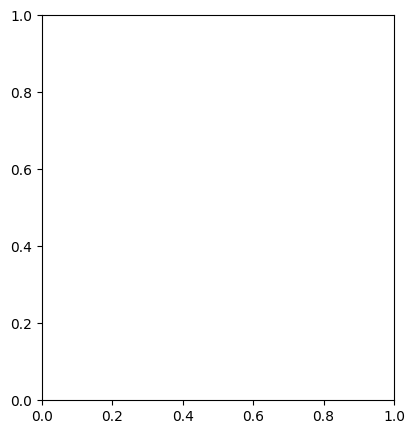

In [37]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

Matriz de confusion

In [ ]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)

Visualizacion de la matriz de confusion mediante mapa de calor

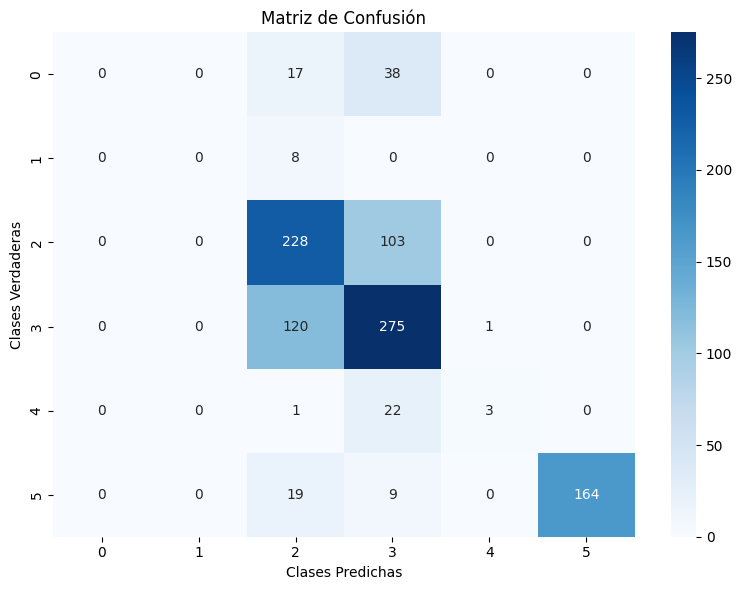

In [ ]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()